<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/workbook_11_decision_trees_and_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring a single decision tree

* Explore how decision tree splits the plane.
Consider different depths.
Gain intuition on when tree performs well and when not.
Try XOR pattern.
* Explore "stability" of the tree, i.e. see that the tree structure may completely change just from adding one point or other small alterations.

In [1]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

def fit_tree(X, y, depth=1):
  model.set_params(max_depth=depth)
  model.fit(X, y)

def predict(X):
  return model.predict(X)

def get_tree():
  return model.tree_

def export_graph():
  from sklearn import tree
  return tree.export_graphviz(model, filled=True, rounded=True, special_characters=True)


In [4]:
#@title Decision tree

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize_tree(X, y, boundaries=True):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5#len(np.unique(y))
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=ListedColormap(rgb), zorder=1)
  
  # Plot the decision boundaries
  def plot_boundaries(i, xlim, ylim):
      if i >= 0:
          tree = get_tree()
      
          if tree.feature[i] == 0:
              ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
              plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
              plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
      
          elif tree.feature[i] == 1:
              ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
              plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
              plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
          
  if boundaries:
      plot_boundaries(0, xlim, ylim)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64


from sklearn import tree as Tree
from sklearn.tree import export_graphviz
import pydotplus

def tree_plot(y):
  dot_data = export_graph()
  graph = pydotplus.graph_from_dot_data(dot_data)  
  graph.set_size('"10,10"')
  y = np.unique(y)

  nodes = graph.get_node_list()
  rgb = np.array([[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]])
  for node in nodes:
    if node.get_label():
      values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
      #print(values)
      s = np.array([0.0, 0.0, 0.0])
      for i,v in enumerate(values):
        s += rgb[y[i]] * v / sum(values)
      #values = [ int(rgb[i] * v / sum(values)) for i,v in enumerate(values)]
      color = '#{:02x}{:02x}{:02x}'.format(int(s[0]), int(s[1]), int(s[2]))
      node.set_fillcolor(color)

  image_base64 = base64.b64encode(graph.create_png()).decode('utf-8').replace('\n', '')
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  images = []
  tree_imgs = []
  for depth in range(1, 10):
    fit_tree(X, y, depth)
    fig = visualize_tree(X, y)
    images.append(figure_to_base64(fig))
    tree_imgs.append(tree_plot(y))

  return IPython.display.JSON({'image': images, 'tree': tree_imgs})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();
    var tree_image = document.getElementById('tree_img');

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }
    var cur_depth = 0;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image[cur_depth];
      tree_image.src = 'data:image/  png;base64,' + params.tree[cur_depth];
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x - 1;
    el.innerHTML = x;
    bg_image.src = 'data:image/  png;base64,' + params.image[cur_depth];
    tree_image.src = 'data:image/  png;base64,' + params.tree[cur_depth];
  }

  </script>
  <canvas id="canvas" width="1200" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1a" name="rate" value="add0" checked="checked"> 
    <label for="r1a">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    </label>
    <br>
    <input type="radio" id="r1b" name="rate" value="add1"> 
    <label for="r1b">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    </label>
    <br>
    <input type="radio" id="r1c" name="rate" value="add2"> 
    <label for="r1c">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(2); "> Add class C
    </label>
    <br>
    <input type="radio" id="r1d" name="rate" value="add3"> 
    <label for="r1d">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(3); "> Add class D
    </label>
    <br>
    <input type="radio" id="r1e" name="rate" value="add4"> 
    <label for="r1e">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(4); "> Add class E
    </label>
    <br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">
    Move data point
    </label>
    <br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">
    Delete data point
    </label>
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke Decision Tree
    </button>
    <br><br>Tree Depth:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
  </div>
  <div style="position:absolute; top:0px; left:825px;">
     <img id="tree_img" style="max-width:600px; max-height:600px; border:3px solid #000000;">
  </div>

  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

# Exploring Random Forest

* Compare Random Forest with $1000$ estimators to a single tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=0)

def fit_forest(X, y):
  model.fit(X, y)
  return model

def predict(X):
  return model.predict(X)

In [ ]:
#@title Random Forest

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize_tree(X, y, boundaries=True):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5#len(np.unique(y))
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=ListedColormap(rgb), zorder=1)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  fit_forest(X, y)
  fig = visualize_tree(X, y)

  return IPython.display.JSON({'image': figure_to_base64(fig)})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }
    var cur_depth = 0;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x - 1;
    el.innerHTML = x;
    bg_image.src = 'data:image/  png;base64,' + params.image;
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1a" name="rate" value="add0" checked="checked"> 
    <label for="r1a">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    </label>
    <br>
    <input type="radio" id="r1b" name="rate" value="add1"> 
    <label for="r1b">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    </label>
    <br>
    <input type="radio" id="r1c" name="rate" value="add2"> 
    <label for="r1c">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(2); "> Add class C
    </label>
    <br>
    <input type="radio" id="r1d" name="rate" value="add3"> 
    <label for="r1d">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(3); "> Add class D
    </label>
    <br>
    <input type="radio" id="r1e" name="rate" value="add4"> 
    <label for="r1e">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(4); "> Add class E
    </label>
    <br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">
    Move data point
    </label>
    <br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">
    Delete data point
    </label>
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke Random Forest
    </button>
  </div>
  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

#Train classifier to recognize digits

Complete the following code.
* Train classifier on MNIST (features are `digits.data`, classes -- `digits.target`)
* Classify the input image

Try single tree and forest with $1000$ estimators. Compare results and do conclusions.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# TRAIN CODE HERE

# Important note:
# This function gets a single 2D array 8x8 representing image
# while predictor accepts Nx16 array,
# where N is number of images (1 in our case).
# Do not forget to transform data appropriately.
def process_symbol(array_8x8):

  # DETECTION CODE HERE
  
  return num_pred

In [ ]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> 8x8x16 grayscale colors </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var ctx_2 = document.getElementById("bin_canvas").getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = [[0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0]]

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = 10;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += 7;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
      binarized[i][j] = 0;

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(8 * idx_x / part.width)][Math.floor(8 * idx_y / part.height)] += 1;
      	
  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
      binarized[i][j] = Math.floor(16 * binarized[i][j] / (part.width * part.height) * (8*8));

  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
    {
      ctx_2.fillStyle = "rgba(" + [256 - 16*binarized[i][j], 256 - 16*binarized[i][j], 256 - 16*binarized[i][j], 255].join(",") + ")";
      ctx_2.fillRect(i * 10, j * 10, 10, 10);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = [[0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0]];
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

#Digits recognition with better resolution

**Does increase in resolution make recognition better?**
Think on this problem for a moment -- the correct answer may be counter-intuitive for you.

* Download full-size (28x28) MNIST (the code is written for you)
* Complete the training code (features are `X`, classes are `y`), train single tree and random forest with $1000$ classifiers
* Complete the detection code
* Test its performance compared to the previous example, do conclusion on how resolution influences the result.

**Starred problem:** if you already know how to use PCA, try reducing dimensionality to get better recognition.

downloaded MNIST shape:  (70000, 784) (70000,)
Normalized images to: 0.0 1.0


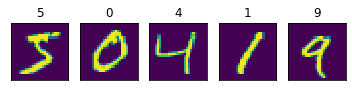

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
print("downloaded MNIST shape: ", mnist.data.shape, mnist.target.shape)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
print("Normalized images to:", X.min(), X.max())
for i, (img, y_) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
    plt.subplot(151 + i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(y_)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# TRAIN CODE HERE

# Important note:
# This function gets a single 2D array 8x8 representing image
# while predictor accepts Nx16 array,
# where N is number of images (1 in our case).
# Do not forget to transform data appropriately.
def process_symbol(num_img):
  
  # DETECTION CODE HERE

  return num_pred

In [ ]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }
      	
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

# Recognizing your own symbols

Now the "vice versa" problem.
The following code implements symbol recognition with a single tree.

* Generate dataset to train the tree. You can create any symbols you like. I've created class Canvas to help you
   - Canvas coordinates are from (0,0) to (100, 100)
   - Use `stroke` function to draw a line compraising segments
   - You can call `stroke` as many times as you need
   - Use `clear` function to clean the canvas 
   - Use `draw` function to see what you've painted
   - Use `get_array_for_dataset` to det symbol in a suitable form for training (Symbol is cut out from canvas, scaled, and transformed into 1D array)
* Train single tree and forest with $1000$ classifiers, compare the results.
* Enrich your dataset with rotated and blurred symbols. Canvas already contains
    - `rotate` to rotate symbol
    - `blur` to blur symbol
    - feel free to use draw whenever you are not sure, what you've drawed
* Train forest with $1000$ classifiers, compare the results on new and old datasets
* Enrich your dataset with somehow warped symbols (think about some randomization when calling `stroke`)
* Train forest with $1000$ classifiers, compare the results on new and old datasets

**Starred problem:** if you already know how to use PCA, try reducing dimensionality to get better recognition.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Canvas:
  def __init__(self):
    self.clear()

  def clear(self):
    self.image = np.zeros((100, 100), np.uint8)

  def stroke(self, key_points_arr):
    x0, y0 = key_points_arr[0]
    for x,y in key_points_arr[1:]:
      cv2.line(self.image, (x0, y0), (x, y), (255), 3) # 3 = line_thickness
      x0, y0 = x, y

  def _get_square_frame(self):
    pos = np.nonzero(self.image)
    x_c, y_c = (pos[1].min() + pos[1].max())/2, (pos[0].min() + pos[0].max())/2
    d = np.max([(pos[1].max() - pos[1].min())/2, (pos[0].max() - pos[0].min())/2])
    return x_c, y_c, d

  def rotate(self, angle_degrees):
    x_c, y_c, _ = self._get_square_frame()
    rot_mat = cv2.getRotationMatrix2D((x_c, y_c), angle_degrees, 1.0)
    self.image = cv2.warpAffine(self.image, rot_mat, self.image.shape[1::-1], flags=cv2.INTER_LINEAR)

  def blur(self, strength=2):
    self.image = cv2.GaussianBlur(self.image, (2*strength+1, 2*strength+1), 0)

  def get_full_image(self):
    return self.image

  def get_scaled_image(self):
    x_c, y_c, d = self._get_square_frame()
    crop_img = self.image[int(y_c - d):int(y_c + d), int(x_c - d):int(x_c + d)]
    scaled_img = cv2.resize(crop_img, (28, 28))
    return scaled_img / 255.0

  def get_array_for_dataset(self):
    return self.get_scaled_image().ravel()

  def draw(self):
    plt.subplot(121)
    plt.imshow(self.image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Full image")
    plt.subplot(122)
    plt.imshow(self.get_scaled_image())
    plt.xticks([])
    plt.yticks([])
    plt.title("Scaled for dataset")
    plt.show()


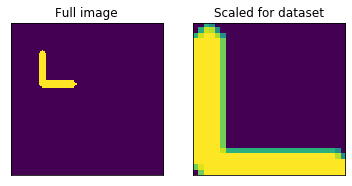

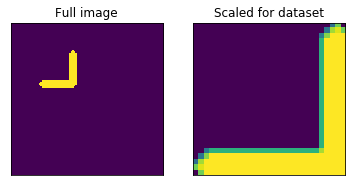

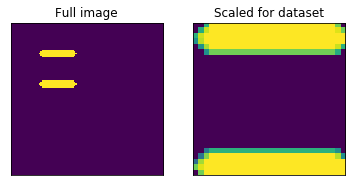

In [ ]:
## Example of drawing symbols
c = Canvas()
# L-symbol
c.clear()
c.stroke([[20, 20], [20, 40], [40, 40]])
c.draw()
# anti-L symbol
c.clear()
c.stroke([[20, 40], [40, 40], [40, 20]])
c.draw()
# = symbol
c.clear()
c.stroke([[20, 40], [40, 40]])
c.stroke([[20, 20], [40, 20]])
c.draw()

In [ ]:
# CREATION OF THE DATASET
X = []
y = []
c = Canvas()

for a in [-10, -5, 0, 5, 10]:
  c.clear()
  c.stroke([[20, 20], [20, 40], [40, 40]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(0)


for a in [-10, -5, 0, 5, 10]:
  c.clear()
  c.stroke([[20, 40], [40, 40], [40, 20]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

names = {0: "L", 1:"anti-L"}

def process_symbol(num_img):
  num_pred = tree.predict([num_img.ravel()])[0]
  return names[num_pred]

In [ ]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }
      	
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

In [ ]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data
Y = iris.target


def one_hot(Y):
  y = np.zeros((Y.size, Y.max()+1))
  y[np.arange(Y.size), Y] = 1
  return y

gini = lambda f: 1 - np.sum((f / np.sum(f, axis=-1)[:,np.newaxis])**2, axis=1)
unpack = lambda arr: (arr[np.newaxis,-1,:], arr[:-1], arr[-1] - arr[:-1])

def best_split(x, y):
  splits, idx = np.unique(x, return_inverse=True)
  f_p, f_l, f_r = unpack(np.cumsum([np.bincount(idx, y_) for y_ in y.T], axis=1).T)
  if not len(f_l) or not len(f_r):
    return splits[0], 0.0
  info_gain = gini(f_p) - np.sum(f_l, axis=1)/np.sum(f_p) * gini(f_l) - np.sum(f_r, axis=1)/np.sum(f_p) * gini(f_r)
  return splits[np.argmax(info_gain)], info_gain[np.argmax(info_gain)]

def best_feature_split(X, y):
  splits = np.array([best_split(X[:,f], y) for f in range(X.shape[1])])
  idx = np.argmax(splits[:,1])
  return idx, splits[idx,0]


class Node:
  def __init__(self, X, y, max_depth=3):
    if max_depth <= 0 or np.sum(np.sum(y, axis=0) > 0) <= 1:
      self.leaf = True
      self.cls = np.argmax(np.sum(y, axis=0))
      return
    self.leaf = False
    self.feature, self.threshold = best_feature_split(X, y)
    left_idxs = (X[:, self.feature] <= self.threshold)
    self.left = Node(X[left_idxs], y[left_idxs], max_depth=max_depth-1)
    self.right = Node(X[np.logical_not(left_idxs)], y[np.logical_not(left_idxs)], max_depth=max_depth-1)
  
  def print(self, depth=0):
    if not self.leaf:
      print("--"*depth + "feature " + str(self.feature) + " <= " + str(self.threshold))
      self.left.print(depth+1)
      self.right.print(depth+1)
    else:
      print("--"*depth + " terminal node, class " + str(self.cls))


y = one_hot(Y)
root = Node(X, y, max_depth=10)
root.print()

feature 2 <= 1.9
-- terminal node, class 0
--feature 3 <= 1.7
----feature 2 <= 4.9
------feature 3 <= 1.6
-------- terminal node, class 1
-------- terminal node, class 2
------feature 3 <= 1.5
-------- terminal node, class 2
--------feature 0 <= 6.7
---------- terminal node, class 1
---------- terminal node, class 2
----feature 2 <= 4.8
------feature 0 <= 5.9
-------- terminal node, class 1
-------- terminal node, class 2
------ terminal node, class 2


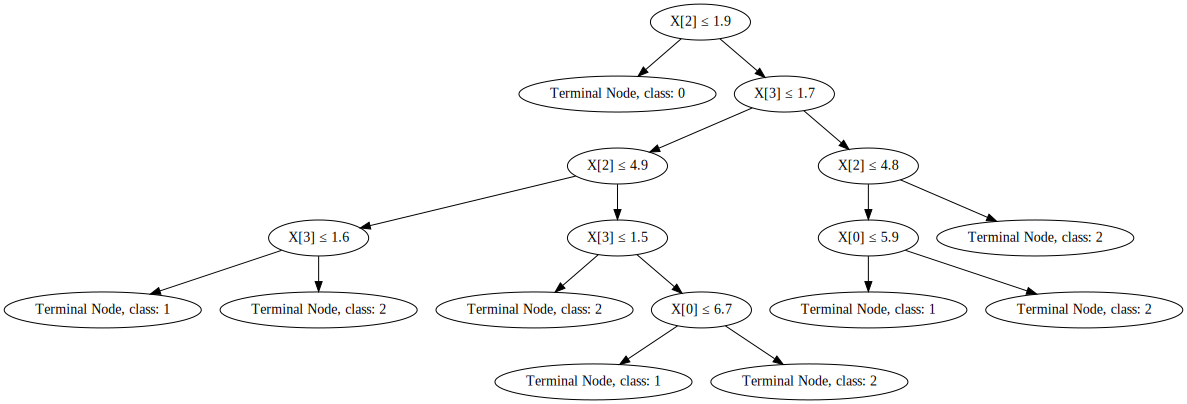

In [ ]:
from graphviz import Digraph

def visualize_tree(tree):
  def add_node(tree, dot):
    if tree.leaf:
      dot.node(name=str(tree), label="Terminal Node, class: " + str(tree.cls))
    else:
      dot.node(name=str(tree), label="X[" + str(tree.feature) + "] ≤ " + str(tree.threshold))

  def add_nodes_edges(tree, dot=None):
    # Create Digraph object
    if dot is None:
      dot = Digraph()
      add_node(tree, dot)

    # Add nodes
    if not tree.leaf and tree.left:
      add_node(tree.left, dot)
      dot.edge(str(tree), str(tree.left))
      dot = add_nodes_edges(tree.left, dot=dot)

    if not tree.leaf and tree.right:
      add_node(tree.right, dot)
      dot.edge(str(tree), str(tree.right))
      dot = add_nodes_edges(tree.right, dot=dot)

    return dot
    
  # Add nodes recursively and create a list of edges
  dot = add_nodes_edges(tree)

  # Visualize the graph
  #display(dot)

  return dot

visualize_tree(root)